<a href="https://colab.research.google.com/github/ThamirisAdriano/iadt-deteccao-anomalias/blob/master/Detector_de_defeitos_em_imagens_com_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import shutil
import os

# Remover a pasta `perfect_pieces` e recriar
shutil.rmtree('perfect_pieces', ignore_errors=True)
os.makedirs('perfect_pieces/perfect', exist_ok=True)
os.makedirs('perfect_pieces/testes', exist_ok=True)

# Listar os arquivos na raiz para garantir que não há duplicatas fora das pastas
print("Arquivos restantes no diretório principal:")
print(os.listdir())


Arquivos restantes no diretório principal:
['.config', 'perfect_pieces', 'sample_data']


In [8]:
from google.colab import files
import os
from shutil import move

# Fazer upload das imagens
uploaded = files.upload()  # Faça o upload de suas imagens.

# Criar pastas para organizar os dados
os.makedirs('perfect_pieces/perfect', exist_ok=True)
os.makedirs('perfect_pieces/testes', exist_ok=True)

# Mover os arquivos para as pastas corretas com base no nome
for file_name in uploaded.keys():
    if 'perfect' in file_name.lower():
        move(file_name, f'perfect_pieces/perfect/{file_name}')  # Mover para a pasta de peças perfeitas
    elif 'undefined' in file_name.lower() or 'test' in file_name.lower():
        move(file_name, f'perfect_pieces/testes/{file_name}')  # Mover para a pasta de peças "testes"
    else:
        print(f"Aviso: {file_name} não pôde ser classificado automaticamente.")


Saving undefined10.jpeg to undefined10.jpeg
Saving undefined9.jpeg to undefined9.jpeg
Saving undefined8.jpeg to undefined8.jpeg
Saving undefined7.jpeg to undefined7.jpeg
Saving undefined6.jpeg to undefined6.jpeg
Saving undefined5.jpeg to undefined5.jpeg
Saving undefined4.jpeg to undefined4.jpeg
Saving undefined3.jpeg to undefined3.jpeg
Saving undefined1.jpeg to undefined1.jpeg
Saving undefined2.jpeg to undefined2.jpeg
Saving perfect9.jpeg to perfect9.jpeg
Saving perfect8.jpeg to perfect8.jpeg
Saving perfect7.jpeg to perfect7.jpeg
Saving perfect6.jpeg to perfect6.jpeg
Saving perfect5.jpeg to perfect5.jpeg
Saving perfect4.jpeg to perfect4.jpeg
Saving perfect3.jpeg to perfect3.jpeg
Saving perfect2.jpeg to perfect2.jpeg
Saving perfect1.jpeg to perfect1.jpeg
Saving perfect10.jpeg to perfect10.jpeg


Classes detectadas: {'perfect': 0, 'testes': 1}


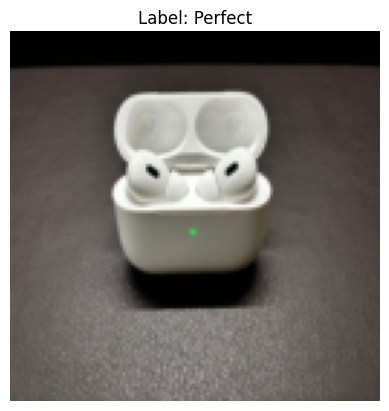

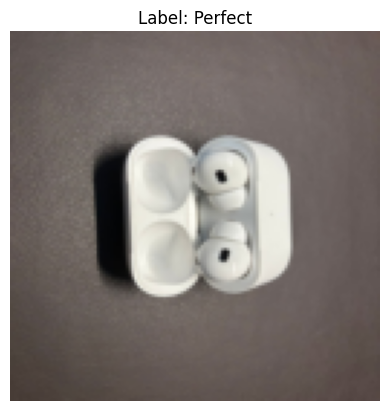

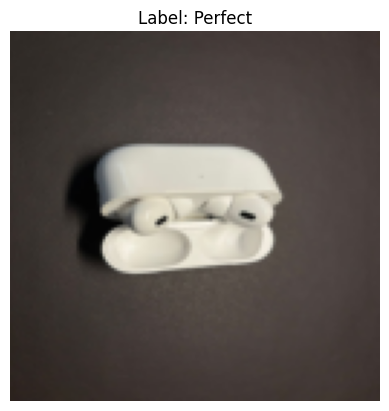

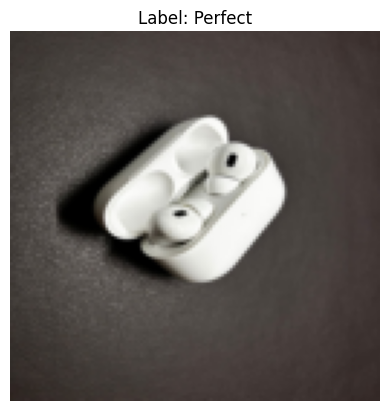

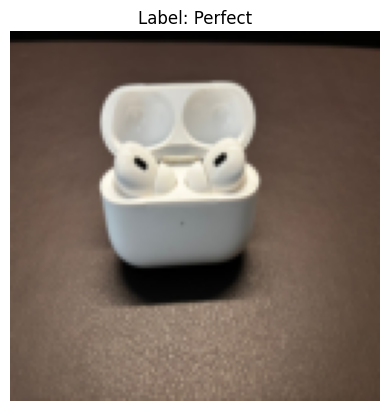

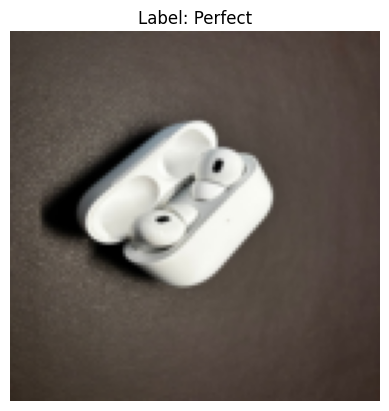

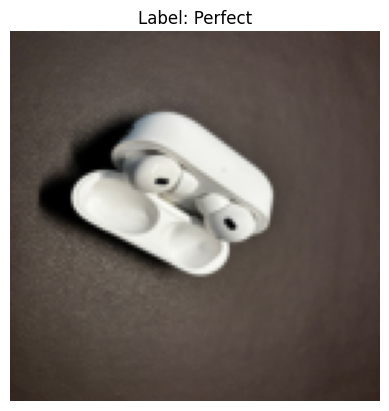

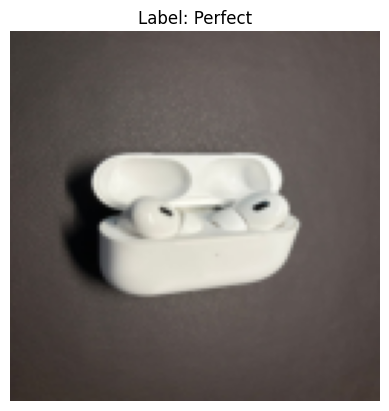

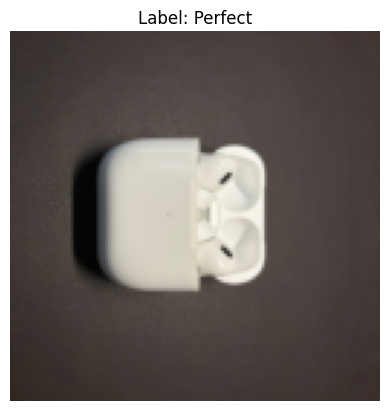

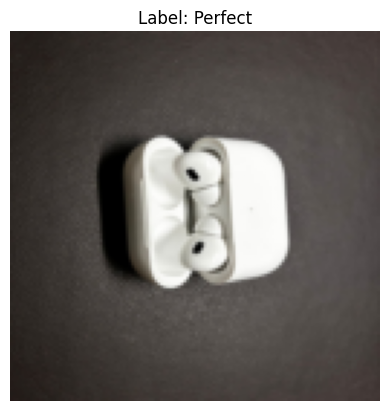

In [9]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

# Configurações básicas
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 128
batch_size = 1

# Transformações nas imagens
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

# Carregando o dataset
dataset = ImageFolder(root='perfect_pieces', transform=transform)
print("Classes detectadas:", dataset.class_to_idx)  # Verificando as classes e seus índices
perfect_idx = dataset.class_to_idx['perfect']

# Separando os dados perfeitos para treino
train_indices = [i for i, (_, label) in enumerate(dataset) if label == perfect_idx]
train_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_indices)
)

# Visualizando imagens do dataset
for img, label in train_loader:
    plt.imshow(img[0].permute(1, 2, 0))
    plt.title(f"Label: {'Perfect' if label == perfect_idx else 'Defective'}")
    plt.axis('off')
    plt.show()


##Definição e Treinamento do Modelo Autoencoder

In [10]:
# Definindo o modelo Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Inicializando o modelo
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Treinamento
epochs = 20
print("Iniciando o treinamento...")
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for img, _ in train_loader:
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")



Iniciando o treinamento...
Epoch [1/20], Loss: 0.0590
Epoch [2/20], Loss: 0.0570
Epoch [3/20], Loss: 0.0521
Epoch [4/20], Loss: 0.0410
Epoch [5/20], Loss: 0.0274
Epoch [6/20], Loss: 0.0190
Epoch [7/20], Loss: 0.0139
Epoch [8/20], Loss: 0.0111
Epoch [9/20], Loss: 0.0087
Epoch [10/20], Loss: 0.0073
Epoch [11/20], Loss: 0.0063
Epoch [12/20], Loss: 0.0057
Epoch [13/20], Loss: 0.0051
Epoch [14/20], Loss: 0.0047
Epoch [15/20], Loss: 0.0044
Epoch [16/20], Loss: 0.0043
Epoch [17/20], Loss: 0.0039
Epoch [18/20], Loss: 0.0037
Epoch [19/20], Loss: 0.0035
Epoch [20/20], Loss: 0.0034


##Avaliação e Detecção de Defeitos nas Imagens

Avaliando as imagens...


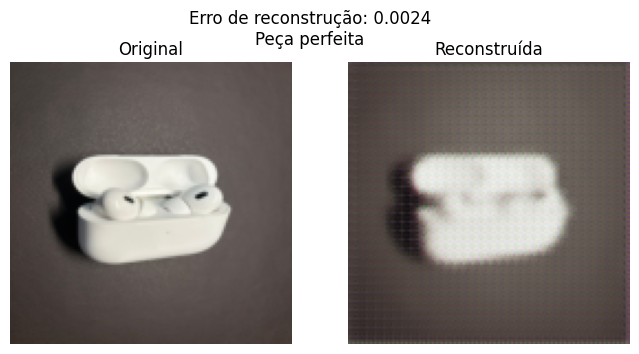

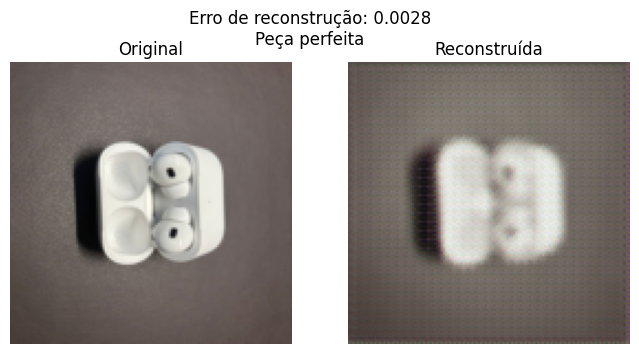

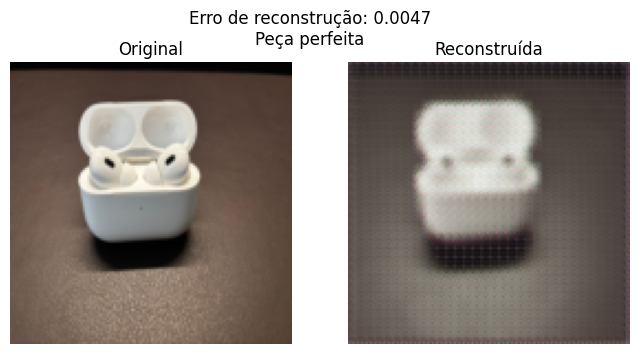

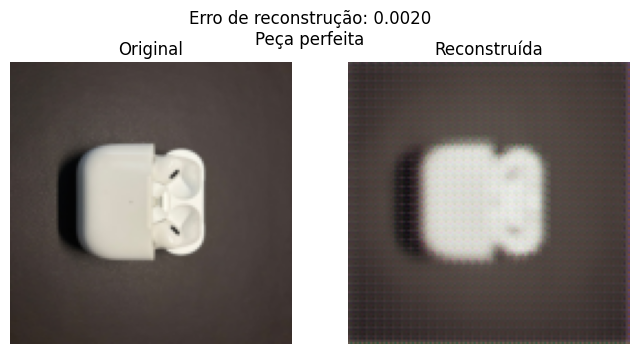

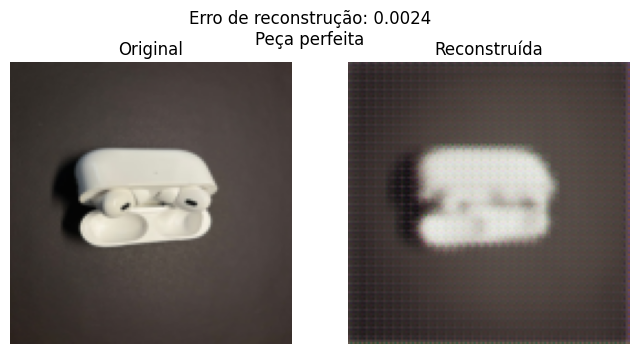

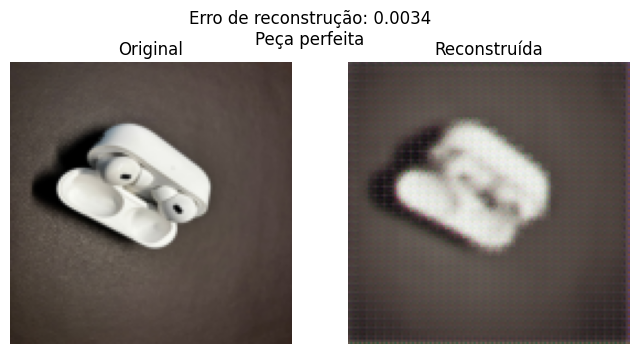

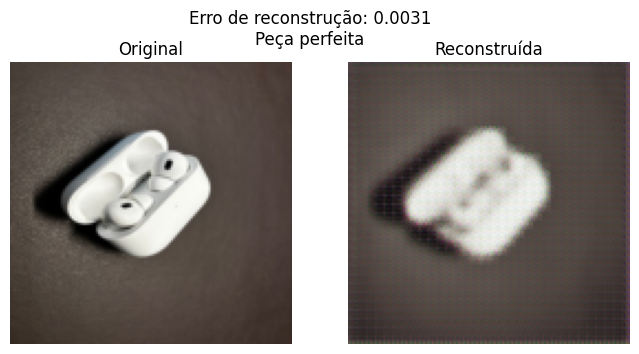

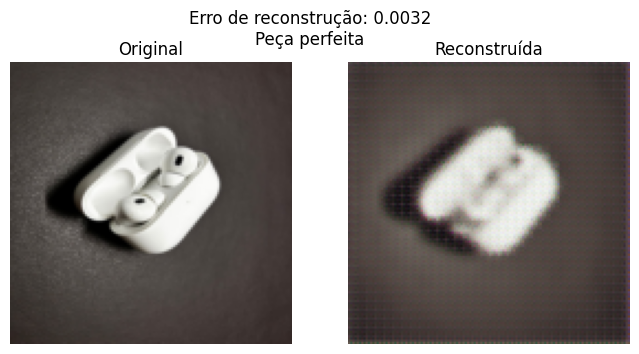

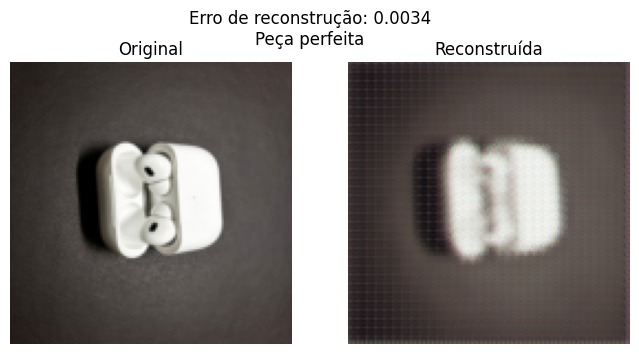

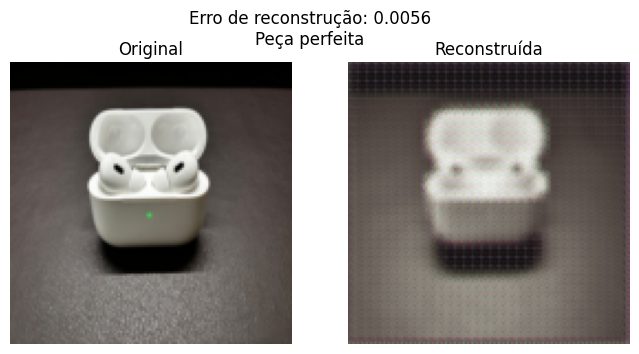

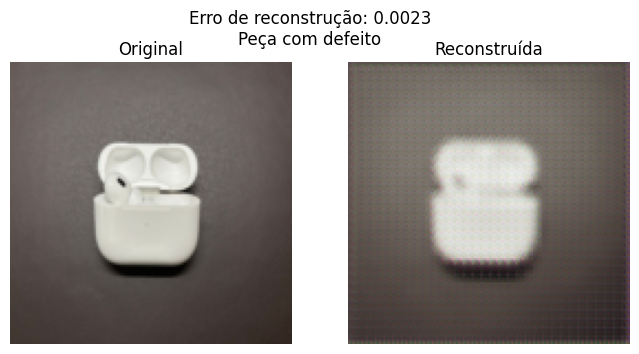

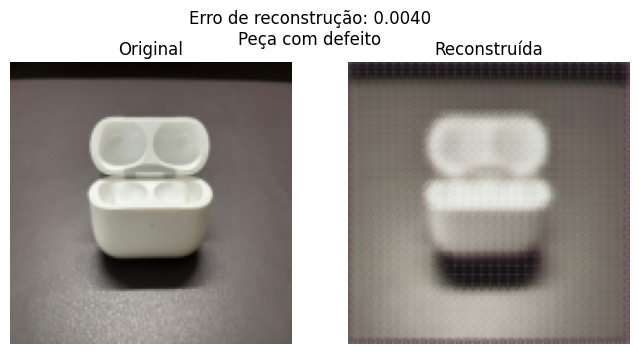

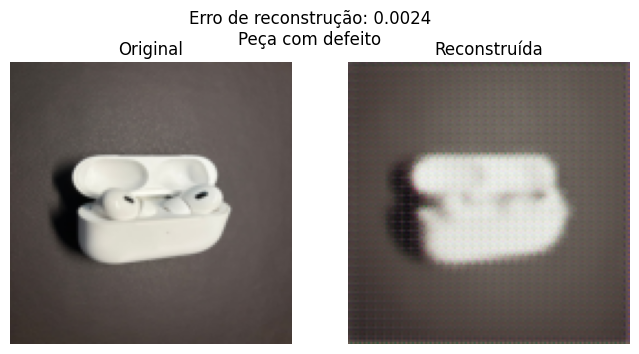

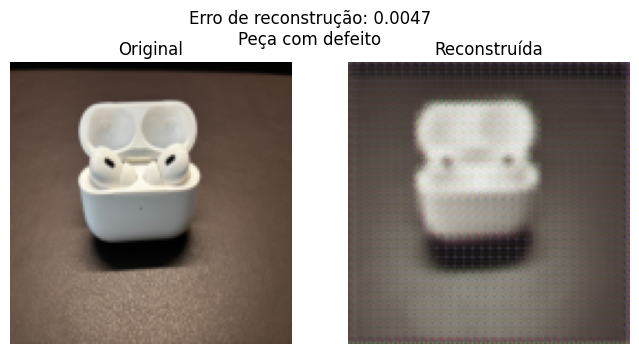

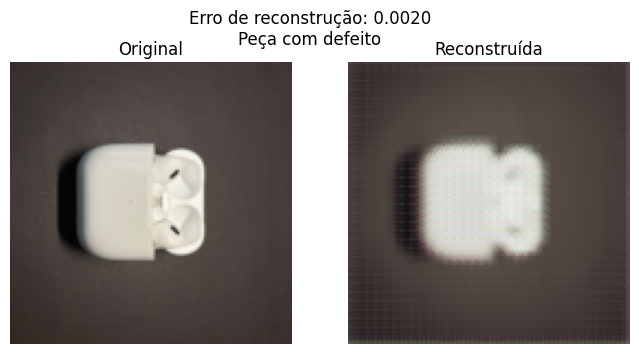

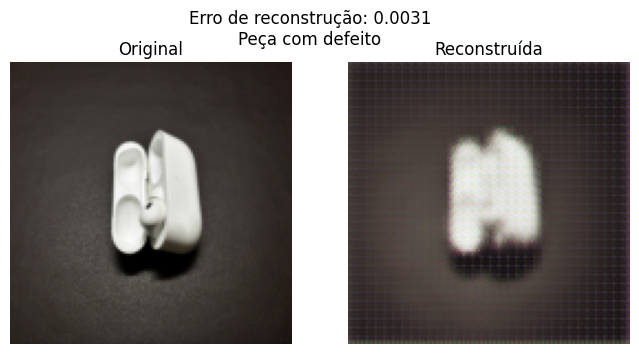

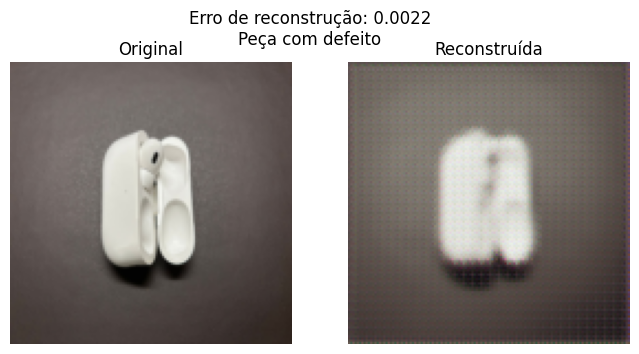

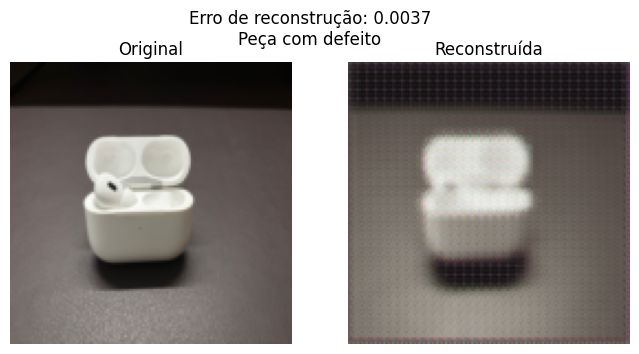

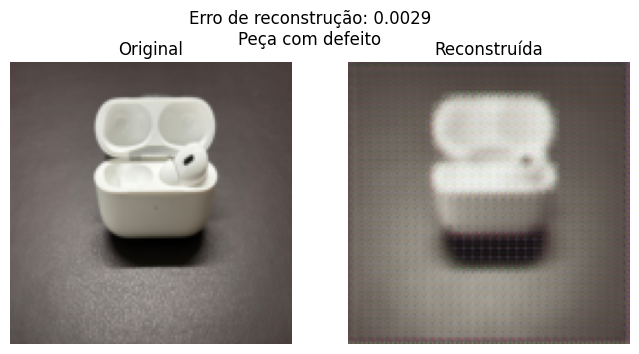

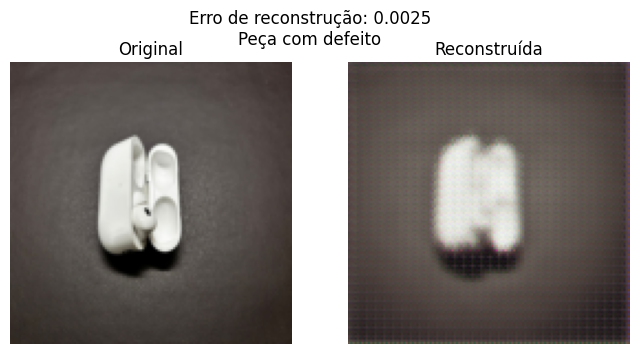

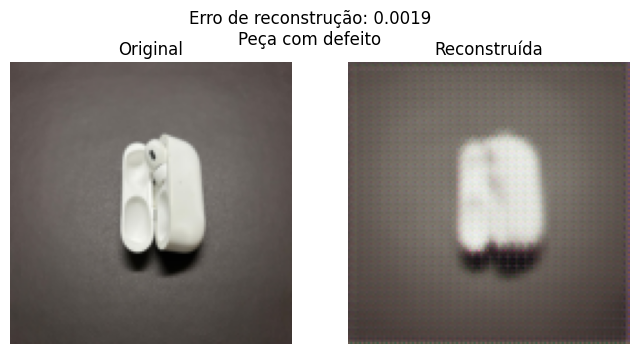

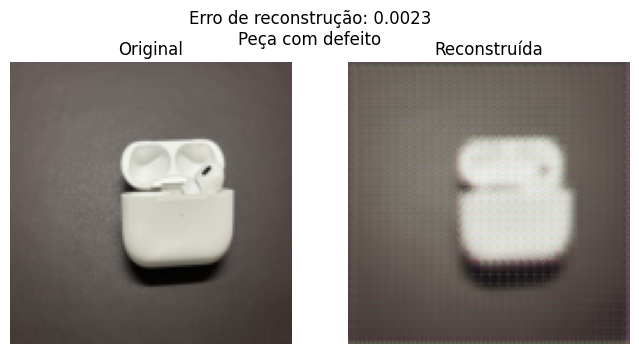

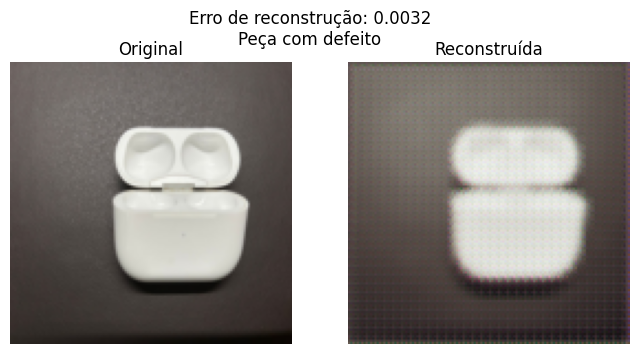

Limiar para detecção de defeitos: 0.0054


In [12]:
# Testando as imagens
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
model.eval()
errors = []

# Avaliação
print("Avaliando as imagens...")
for img, label in test_loader:
    img = img.to(device)
    output = model(img).detach()
    error = torch.mean((img - output) ** 2).item()
    errors.append((error, label.item()))

    # Visualizando original e reconstruída
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0].permute(1, 2, 0).cpu())
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(output[0].permute(1, 2, 0).cpu())
    plt.title("Reconstruída")
    plt.axis('off')

    plt.suptitle(f"Erro de reconstrução: {error:.4f}\n{'Peça perfeita' if label == perfect_idx else 'Peça com defeito'}")
    plt.show()

# Definindo um limiar dinâmico para detecção de defeitos
perfect_errors = [e for e, l in errors if l == perfect_idx]
threshold = np.mean(perfect_errors) + 2 * np.std(perfect_errors)
print(f"Limiar para detecção de defeitos: {threshold:.4f}")
